<a href="https://colab.research.google.com/github/Lilchoto3/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# MY CODE STARTS HERE

# I'm going to copy over my code from yesterday's assignment
import numpy as np
from sklearn.model_selection import train_test_split

# split train into train and val
train, val = train_test_split(train, train_size=.8, test_size=.2, stratify=train['status_group'], random_state=42)

# I'm going to start by mimicing the lecture and cleaning it like how they did
def fix_data(X):
  X = X.copy() # avoid copy warnings

  # Clean zeros
  X['latitude'] = X['latitude'].replace(-2e-08,0)
  cols = ['longitude','latitude','construction_year','gps_height','population']
  for col in cols:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING']= X[col].isnull()
  
  # Drop duplicate columns
  duplicates = ['quantity_group','payment_type']
  X = X.drop(columns=duplicates)

  # Drop recorded_by and id, as they're unhelpful columns of data
  X = X.drop(columns=['recorded_by','id'])

  # Convert date_recorded to a datetime format
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  # Extract individual date components from the new format and get rid of the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  # Create a feature that shows how many years it's been since its construction
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  return X

train = fix_data(train)
val = fix_data(val)
test = fix_data(test)

# set up features and target
target = 'status_group'

features = train.drop(columns=[target])

# grab numerical features
num_feats = features.select_dtypes(include='number').columns.tolist()

# grab low-cardinal catagorical features
cat_feats = features.select_dtypes(exclude='number').nunique()
cat_feats = cat_feats[cat_feats <= 50].index.tolist()

# concat the lists
features = num_feats + cat_feats

# Create feature and target matricies
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [7]:
# Modelling starts here

# This time around I'm going to see if I can use ROC AUCs with Randomized Searches
# to fine-tune my RandomForest to the max.
# From what I know so far, my run of max_depth=20, n_estimators=100 was very successful -
# my best run so far. I want to see if I can use Randomized Searches to fine-tune
# those values and get even better results using some sort of loop.
# Take the best results of a search, set it as the middle value of a more precise
# search, rinse and repeat.

# Set up pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import decimal

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# I plan to update these as I fine-tune the searches
max_depth = 20
n_estimators = 100
max_features = .3
param_distributions = {
    'simpleimputer__strategy': ['mean','median']
}

# run the search 3 times, each time getting more specialized
for x in [.5, .25, .1]:
  # set up each feature for the parameters
  param_distributions['randomforestclassifier__max_depth'] = range(
      int(max_depth - (max_depth * x)),
      int(max_depth + (max_depth * x) + 2),
      1
  )
  param_distributions['randomforestclassifier__n_estimators'] = range(
      int(n_estimators - (n_estimators * x)),
      int(n_estimators + (n_estimators * x) + 1),
      int(x * 10)
  )
  param_distributions['randomforestclassifier__max_features'] = [(x/1000) for x in range(
      int((max_features - (max_features * x)) * 1000),
      int((max_features + (max_features * x)) * 1000 + 1),
      int((max_features / 10) * 1000)
  )]

  # do the search
  search = RandomizedSearchCV(
      pipeline,
      param_distributions=param_distributions,
      n_iter=10,
      cv=5,
      scoring='accuracy',
      verbose=10,
      return_train_score=True,
      n_jobs=-1
  )

  # fit it to the data to get accuracies
  search.fit(X_train, y_train)

  # update the variables to run the loop again
  max_depth = search.best_params_['randomforestclassifier__max_depth']
  n_estimators = search.best_params_['randomforestclassifier__n_estimators']
  max_features = search.best_params_['randomforestclassifier__max_features']

  print('Best Hyperparameters:',search.best_params_)
  print('Cross Validation Accuracy:',search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.2min finished


Best Hyperparameters: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 95, 'randomforestclassifier__max_features': 0.18, 'randomforestclassifier__max_depth': 20}
Cross Validation Accuracy: 0.8038930976430976
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.8min finished


Best Hyperparameters: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 83, 'randomforestclassifier__max_features': 0.135, 'randomforestclassifier__max_depth': 21}
Cross Validation Accuracy: 0.8048400673400673
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.7min finished


Best Hyperparameters: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 82, 'randomforestclassifier__max_features': 0.134, 'randomforestclassifier__max_depth': 20}
Cross Validation Accuracy: 0.8055765993265993


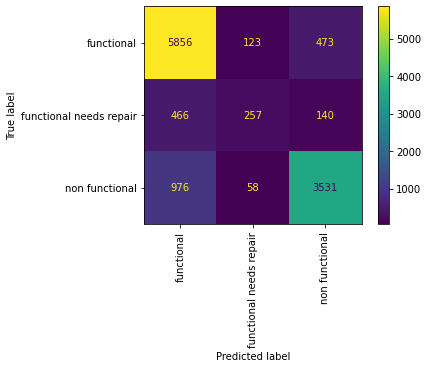

In [14]:
# okay, now that that's done, I can optimize it with ROC AUC

# First, grab the best model from the last search
pipeline = search.best_estimator_
pipeline.fit(X_train, y_train)

# make a confusion matrix and see where the problems are
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f',xticks_rotation='vertical')

# Grab the predicted probas for fiddling with thresholds later
y_pred_proba = pipeline.predict_proba(X_val)[:,1]

In [17]:
# Set up an interactive confusion matrix slash distplot
from sklearn.metrics import classification_report
import seaborn as sns
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
def show_confusion_matrix_graph(y_true, y_pred_proba, good_thresh=0.5, ok_thresh=0.25):
  y_pred = []
  for val in y_pred_proba:
    if val > good_thresh:
      y_pred.append('functional')
    elif val < good_thresh and val > ok_thresh:
      y_pred.append('functional needs repair')
    else:
      y_pred.append('non functional')
  ax = sns.distplot(y_pred_proba)
  ax.axvline(good_thresh, color='green')
  ax.axvline(ok_thresh, color='red')
  plt.show()
  print(classification_report(y_val, y_pred))

interact(show_confusion_matrix_graph, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba),
         good_thresh=(0, 1, .02),
         ok_thresh=(0, 1, .02))

interactive(children=(FloatSlider(value=0.5, description='good_thresh', max=1.0, step=0.02), FloatSlider(value…

<function __main__.show_confusion_matrix_graph>

In [20]:
# this tells me nothing other than this was a bad idea, lets not implement it

# instead lets see what ROC AUC tells me
y_pred = pipeline.predict(X_val)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

# This doesn't work because my output is not binary and also not numerical

ValueError: ignored

In [21]:
# If the above code is working, it means I updated it to look for only which water pumps are functional
# or in need of repair, if it's not, feel free to ignore it.
# get my predictions
y_pred = pipeline.predict(X_test)

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
kaggle_sub = pd.DataFrame(data=y_pred,index=test['id'],columns=['status_group'])

kaggle_sub.head()

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [22]:
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [0]:
kaggle_sub.to_csv('Zachary_Luck_03_19_2020_Lambda_Kaggle_Challenge.csv')

In [26]:
# Check to make sure it works
testdf = pd.read_csv('Zachary_Luck_03_19_2020_Lambda_Kaggle_Challenge.csv')

print(testdf.shape)
testdf.head()

(14358, 2)


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
